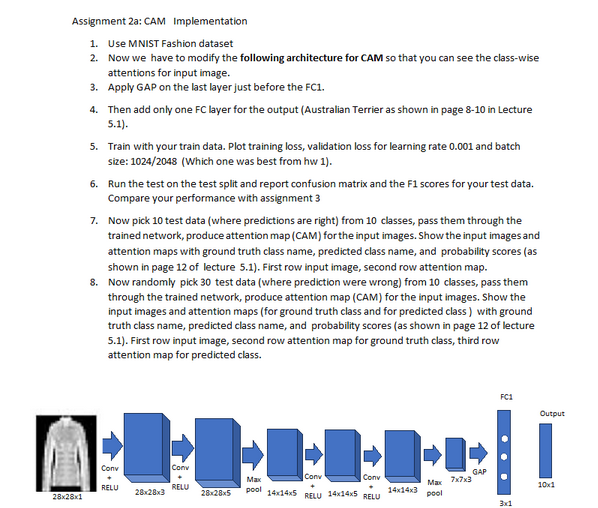

In [ ]:
# ======================================================
# Code Block 1: Imports
# ======================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
# ======================================================
# Code Block 2: Model Definition (FashionCNN_CAM)
# ======================================================
class FashionCNN_CAM(nn.Module):
    """
    CNN with Global Average Pooling (GAP) for Class Activation Map (CAM).

    Architecture:
    1) (Conv -> ReLU -> Conv -> ReLU -> MaxPool) ->
    2) (Conv -> ReLU -> Conv -> ReLU -> MaxPool) ->
    3) Global Average Pool ->
    4) FC -> Output(10)
    """

    def __init__(self):
        super(FashionCNN_CAM, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)

        # Fully Connected (FC) layer from the GAP output to 10 classes.
        self.fc = nn.Linear(3, 10)  # Because final conv out_channels=3

        # Weight initialization (Xavier init)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Stage 1: Convolution, ReLU, MaxPool
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # input: 28x28 -> 14x14

        # Stage 2: Another Convolution, ReLU, MaxPool
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)  # input: 14x14 -> 7x7

        # x is now shape (batch_size, 3, 7, 7).

        # Global Average Pooling (GAP) over spatial dimensions: result is (batch_size, 3).
        gap = F.adaptive_avg_pool2d(x, (1, 1))  # (batch_size, 3, 1, 1)
        gap = gap.view(gap.size(0), -1)         # (batch_size, 3)

        # Final FC layer to get predictions for 10 classes.
        out = self.fc(gap)  # shape (batch_size, 10)

        # Return both the logits and the feature maps for CAM visualization.
        return out, x

In [ ]:
# ======================================================
# Code Block 3: Training and Validation Functions
# ======================================================
def train_one_epoch_cam(model, dataloader, optimizer, criterion, device):
    """
    Single epoch training function.
    """
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, _ = model(images)  # We don't need the feature maps here, just the outputs.
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Return average loss for the epoch.
    return running_loss / len(dataloader.dataset)


def validate_one_epoch_cam(model, dataloader, criterion, device):
    """
    Single epoch validation function.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

    # Return average validation loss for this epoch.
    return running_loss / len(dataloader.dataset)

In [ ]:
# ======================================================
# Code Block 4: CAM Generation Function
# ======================================================
def generate_cam(model, input_image, class_idx):
    """
    Generate a class activation map for a single input image and a specified class index.

    input_image: Tensor of shape [1, 1, 28, 28].
    class_idx: Integer index for which class's CAM to generate.

    Returns: A 2D CAM (7x7) as a NumPy array.
    """
    model.eval()
    with torch.no_grad():
        # Forward pass to get outputs and feature maps.
        output, feature_maps = model(input_image)  # feature_maps shape = [1, 3, 7, 7]

        # FC weights for this particular class.
        fc_weights = model.fc.weight[class_idx]  # shape [3]

        # Weighted sum of the feature maps (channels).
        cam = torch.zeros((7,7), device=input_image.device)
        for c in range(3):
            cam += fc_weights[c] * feature_maps[0, c, :, :]

        cam = cam.cpu().numpy()
        # Normalize the CAM for visualization.
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [ ]:
# ======================================================
# Code Block 5: Main Training Loop
# ======================================================
def train_cam_model(num_epochs=10, lr=0.001, batch_size=1024):
    """
    Trains the FashionCNN_CAM model on the FashionMNIST dataset.
    Returns the trained model and the test DataLoader.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transforms for the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Download and create datasets
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, transform=transform, download=True
    )

    # Split train dataset into (train + validation)
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = FashionCNN_CAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists for tracking loss
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch_cam(model, train_loader, optimizer, criterion, device)
        val_loss = validate_one_epoch_cam(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Plot loss curves
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (CAM Model)')
    plt.legend()
    plt.show()

    # Evaluation on the test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs, _ = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Calculate Accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = np.mean(all_preds == all_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (CAM Model)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # F1 Scores
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    print(f"F1 macro: {f1_macro:.4f}, F1 micro: {f1_micro:.4f}")

    return model, test_loader

In [ ]:
# ======================================================
# Code Block 6: Demo - Generating and Visualizing CAMs
# ======================================================
def visualize_cams(model, test_loader, device, num_correct=10, num_incorrect=30):
    """
    Visualize Class Activation Maps for correct and incorrect predictions.
    """
    model.eval()

    # Gather all predictions
    all_images, all_labels, all_preds = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs, _ = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_images.append(images.cpu())
            all_labels.append(labels)
            all_preds.append(preds.cpu())

    # Concatenate across all batches
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_preds  = torch.cat(all_preds, dim=0)

    # Convert to numpy for indexing
    all_labels_np = all_labels.numpy()
    all_preds_np  = all_preds.numpy()

    # Identify correct and incorrect indices
    correct_indices = np.where(all_labels_np == all_preds_np)[0]
    incorrect_indices = np.where(all_labels_np != all_preds_np)[0]

    # Shuffle indices to pick random samples
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)

    # -----------------------------------------------------
    # Part A: Visualize correct predictions
    # -----------------------------------------------------
    correct_class_chosen = set()
    correct_samples = []

    # Choose up to `num_correct` correct samples,
    # ideally covering multiple classes if possible.
    for idx in correct_indices:
        label = all_labels_np[idx]
        if label not in correct_class_chosen:
            correct_class_chosen.add(label)
            correct_samples.append(idx)
        if len(correct_class_chosen) == 10 or len(correct_samples) == num_correct:
            break

    # Generate and plot CAM for each correct sample
    for i, idx in enumerate(correct_samples):
        img_tensor = all_images[idx].unsqueeze(0).to(device)  # shape [1, 1, 28, 28]
        label = all_labels_np[idx]
        pred = all_preds_np[idx]

        # Generate CAM for the ground truth (which is also the predicted class)
        cam_gt = generate_cam(model, img_tensor, class_idx=label)

        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        # Original image
        ax[0].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[0].set_title(f"Correct #{i}\nGT = {label}, Pred = {pred}")
        ax[0].axis('off')

        # CAM overlay
        ax[1].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[1].imshow(cam_gt, alpha=0.5, cmap='jet')
        ax[1].set_title("CAM (GT Class)")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

    # -----------------------------------------------------
    # Part B: Visualize incorrect predictions
    # -----------------------------------------------------
    # We'll just pick up to `num_incorrect` samples
    incorrect_samples = incorrect_indices[:num_incorrect]

    for i, idx in enumerate(incorrect_samples):
        img_tensor = all_images[idx].unsqueeze(0).to(device)
        label = all_labels_np[idx]
        pred = all_preds_np[idx]

        # Generate CAM for ground truth & predicted class
        cam_gt = generate_cam(model, img_tensor, class_idx=label)
        cam_pred = generate_cam(model, img_tensor, class_idx=pred)

        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        # Original image
        ax[0].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[0].set_title(f"Incorrect #{i}\nGT = {label}, Pred = {pred}")
        ax[0].axis('off')

        # CAM for ground truth class
        ax[1].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[1].imshow(cam_gt, alpha=0.5, cmap='jet')
        ax[1].set_title("CAM (GT Class)")
        ax[1].axis('off')

        # CAM for predicted class
        ax[2].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[2].imshow(cam_pred, alpha=0.5, cmap='jet')
        ax[2].set_title("CAM (Pred Class)")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 350kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.21MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.47MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/5]  Train Loss: 2.2948  Val Loss: 2.2814
Epoch [2/5]  Train Loss: 2.2356  Val Loss: 2.1676
Epoch [3/5]  Train Loss: 2.0622  Val Loss: 1.9575
Epoch [4/5]  Train Loss: 1.8369  Val Loss: 1.7408
Epoch [5/5]  Train Loss: 1.6453  Val Loss: 1.5753


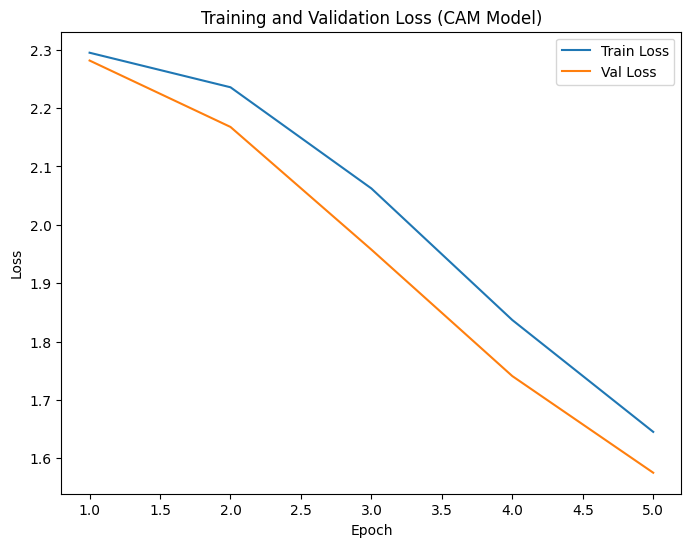

Accuracy: 39.44%


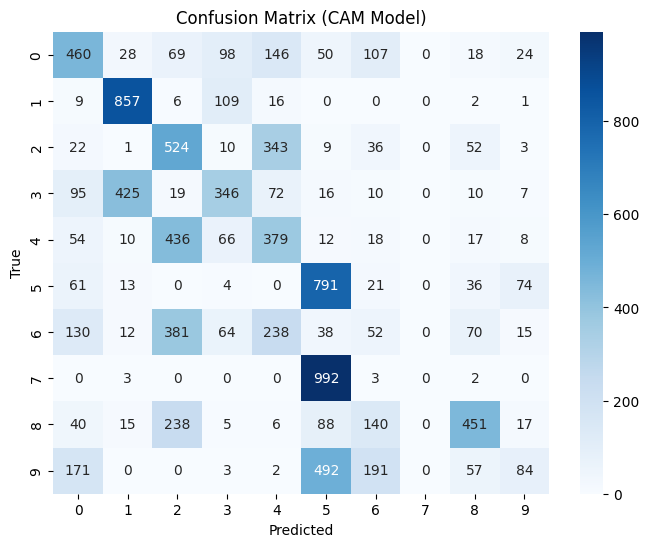

F1 macro: 0.3499, F1 micro: 0.3944


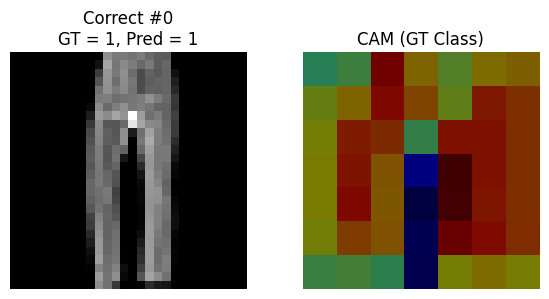

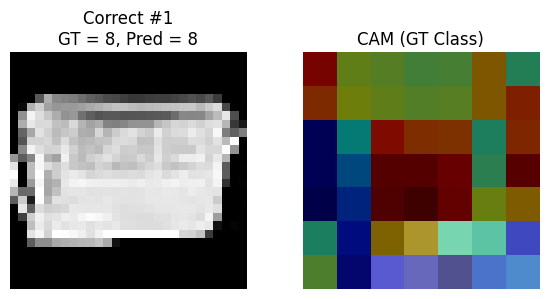

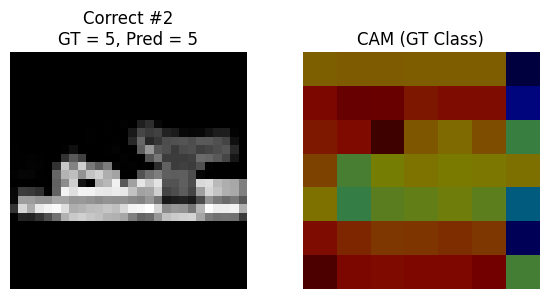

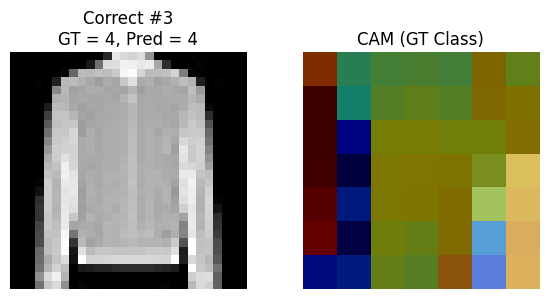

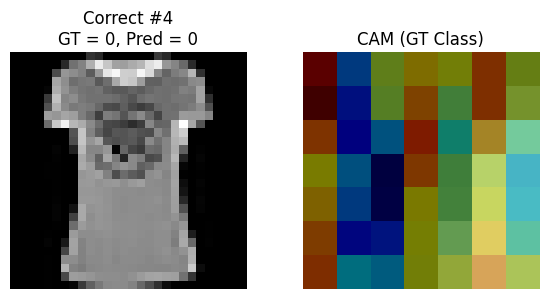

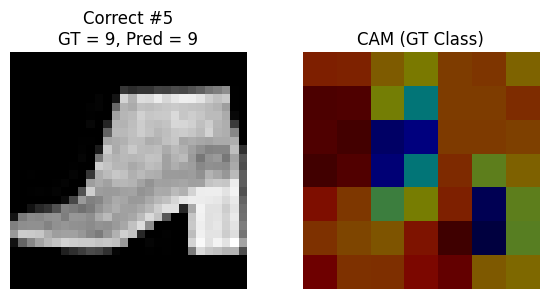

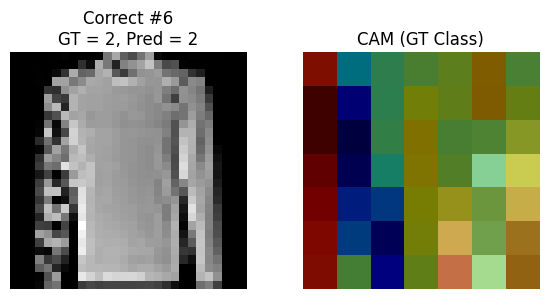

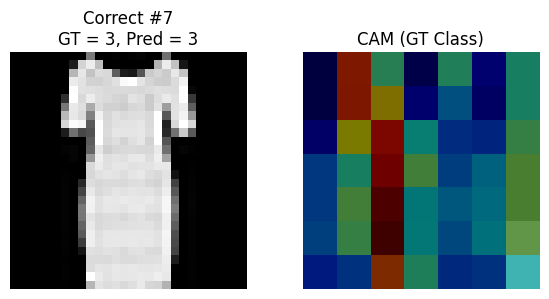

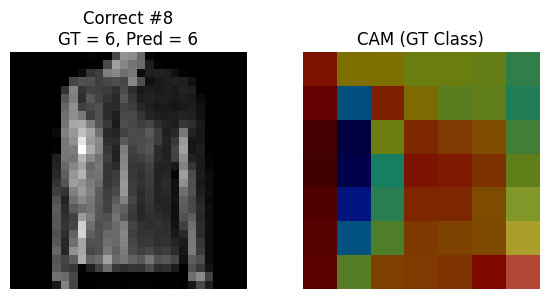

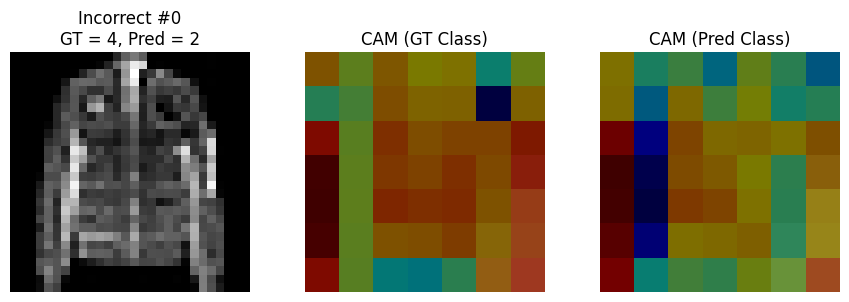

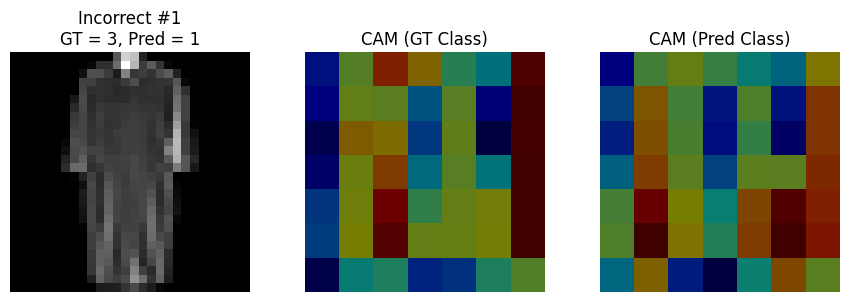

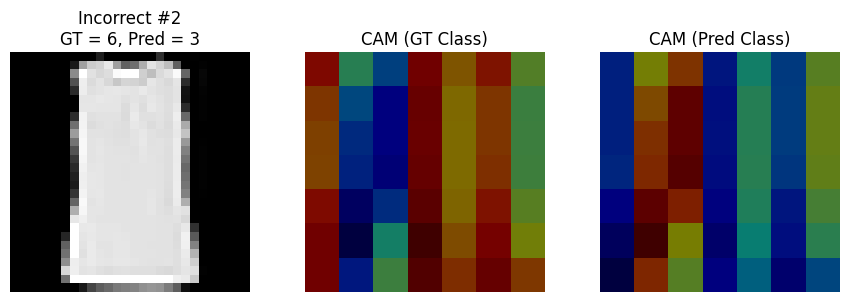

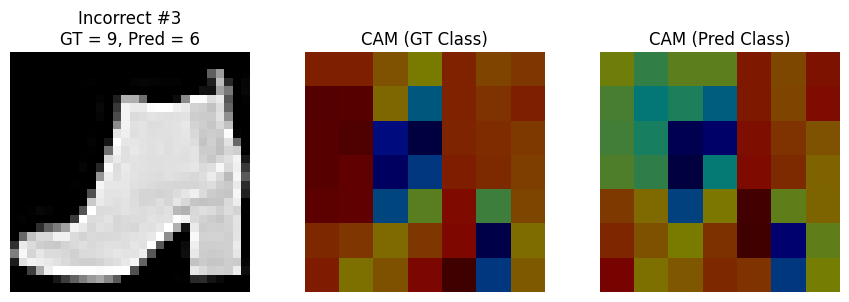

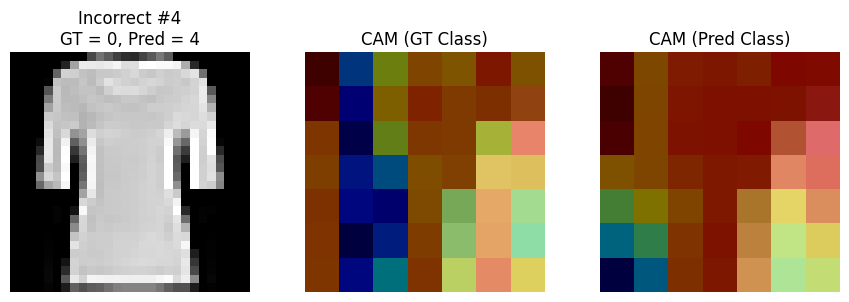

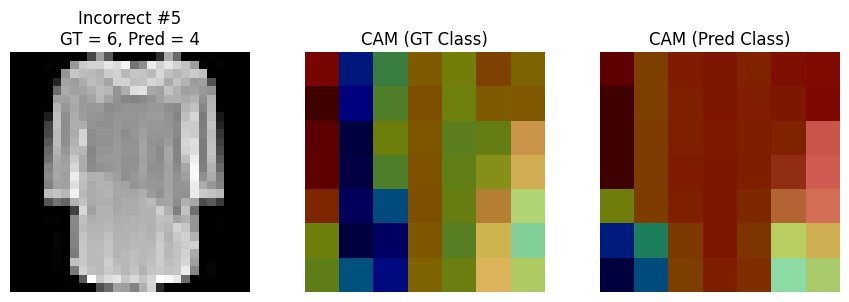

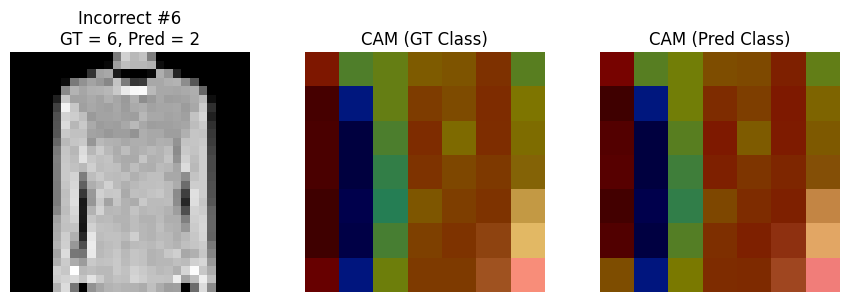

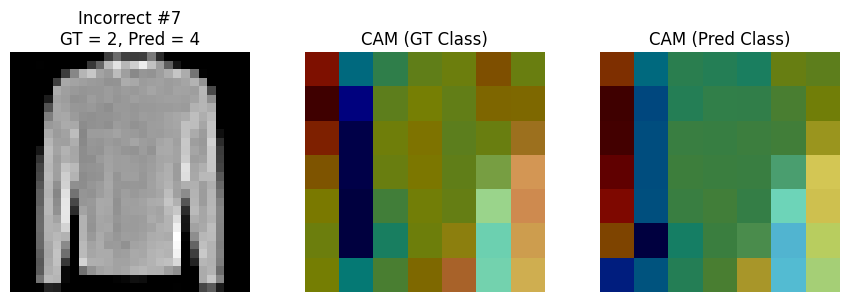

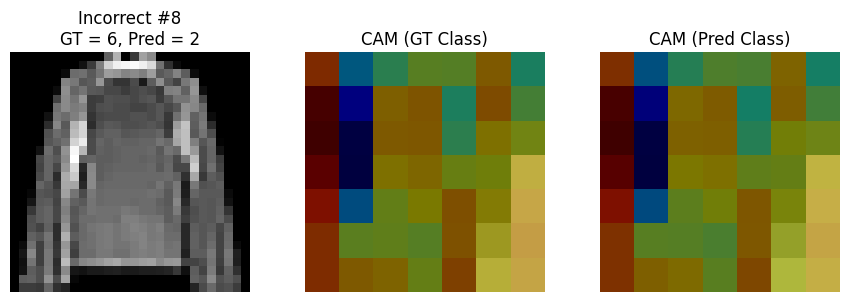

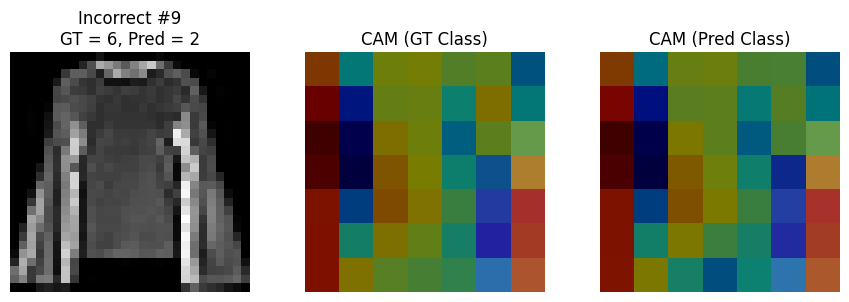

In [ ]:
# ======================================================
# Code Block 7: Execution / Main Guard
# ======================================================
if __name__ == "__main__":
    # Detect and set device (GPU if available, else CPU).
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Train the model (default: 5 epochs, lr=0.001, batch_size=1024).
    cam_model, test_loader = train_cam_model(num_epochs=5, lr=0.001, batch_size=1024)

    # Visualize some CAMs for correct and incorrect predictions.
    visualize_cams(cam_model, test_loader, device, num_correct=10, num_incorrect=10)

Epoch [1/10] - Train Loss: 1.5968 | Val Loss: 1.2366
Epoch [2/10] - Train Loss: 0.9622 | Val Loss: 0.8241
Epoch [3/10] - Train Loss: 0.7345 | Val Loss: 0.6736
Epoch [4/10] - Train Loss: 0.6240 | Val Loss: 0.5652
Epoch [5/10] - Train Loss: 0.5538 | Val Loss: 0.4943
Epoch [6/10] - Train Loss: 0.5099 | Val Loss: 0.4729
Epoch [7/10] - Train Loss: 0.4888 | Val Loss: 0.4419
Epoch [8/10] - Train Loss: 0.4683 | Val Loss: 0.4286
Epoch [9/10] - Train Loss: 0.4512 | Val Loss: 0.4045
Epoch [10/10] - Train Loss: 0.4347 | Val Loss: 0.3874


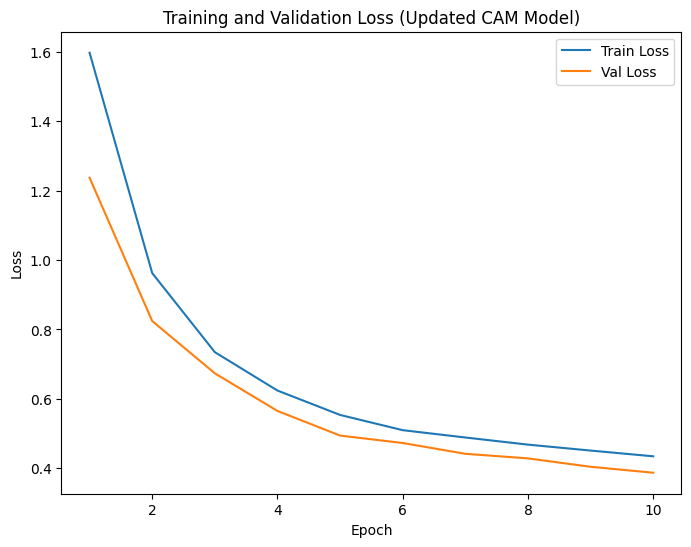

Test Accuracy: 85.82%


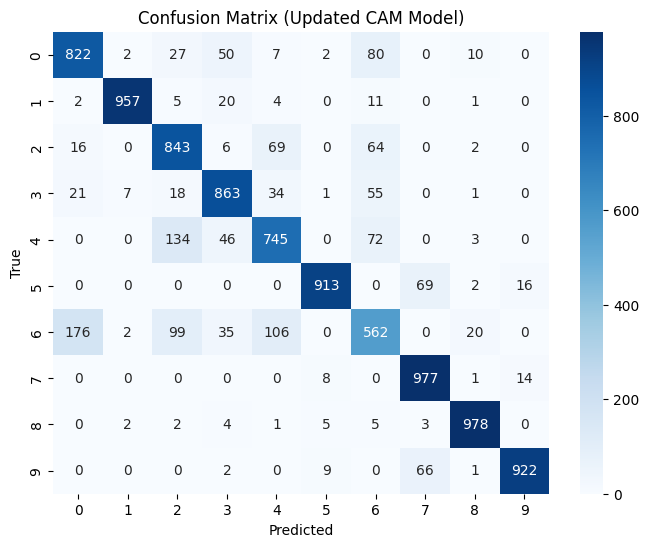

F1 macro: 0.8568, F1 micro: 0.8582


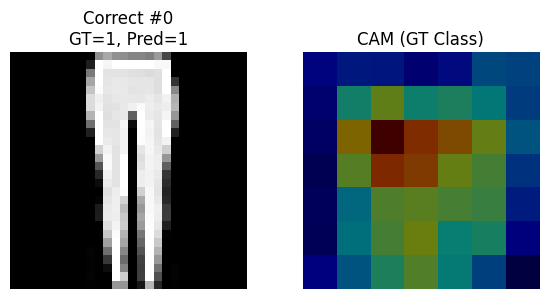

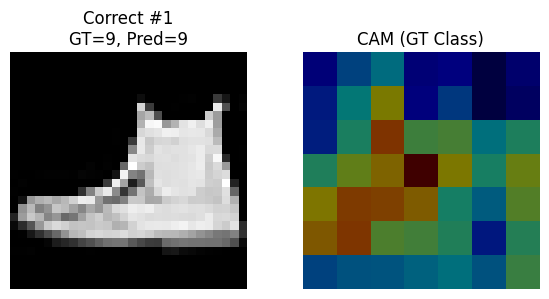

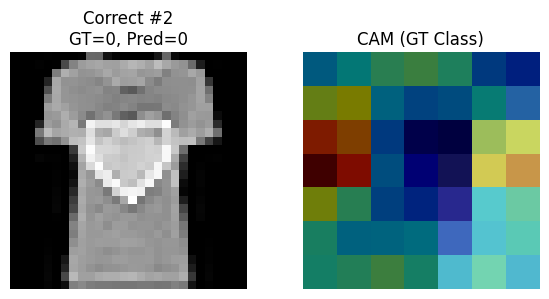

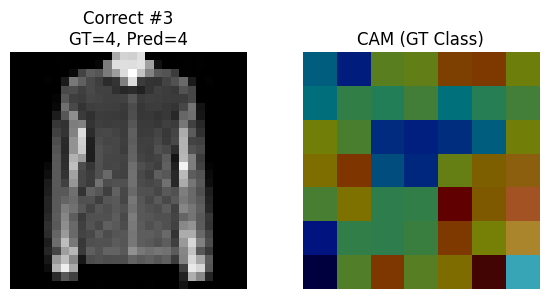

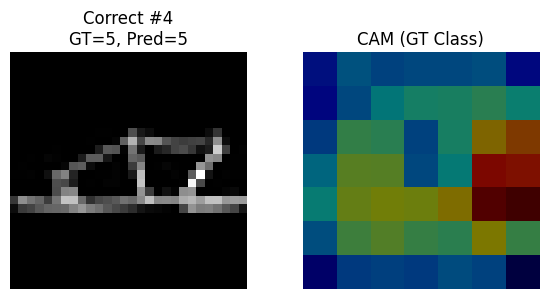

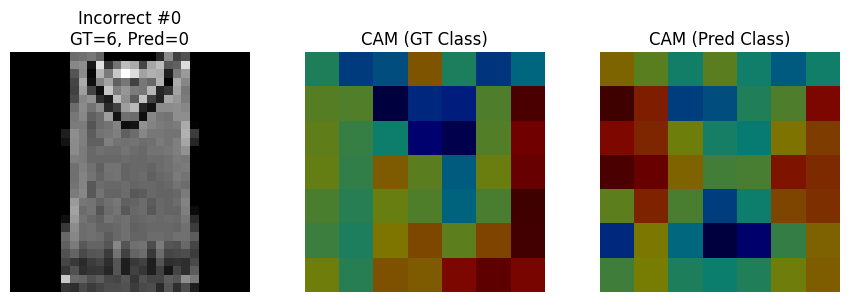

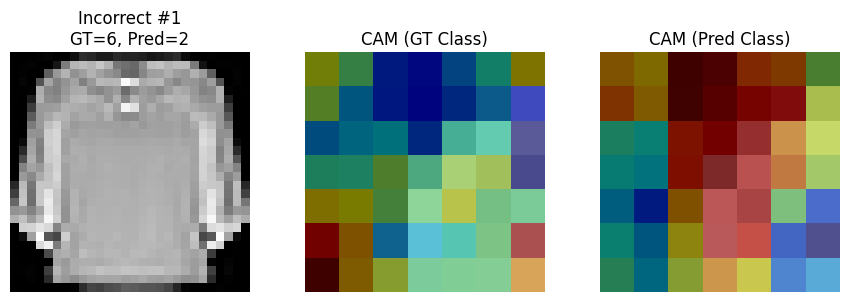

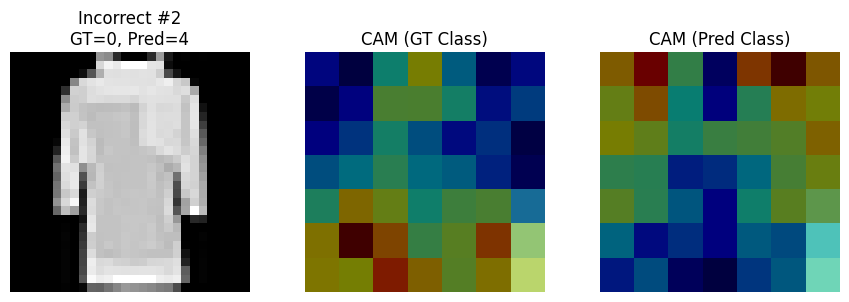

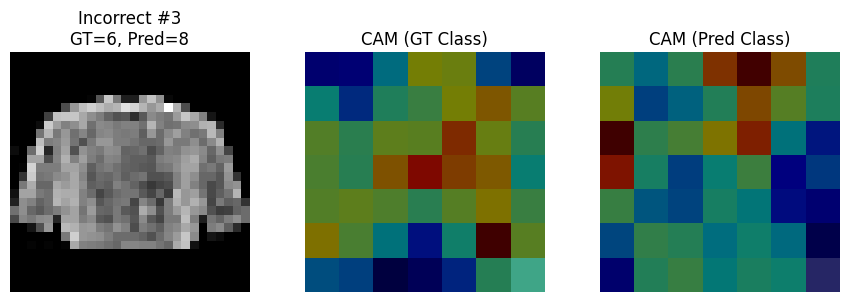

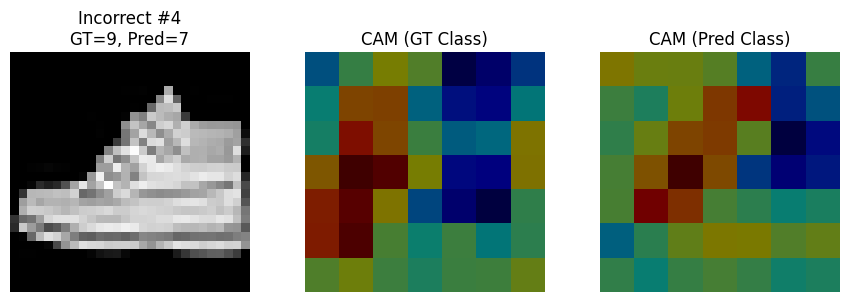

In [ ]:
#######################################################
# COMPLETE CODE: Updated CNN + Data Augmentation + LR Scheduler
#######################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

#######################################################
# 1. UPDATED MODEL: FashionCNN_CAM
#######################################################
class FashionCNN_CAM(nn.Module):
    """
    CNN with:
      - More channels
      - Batch Normalization
      - Dropout
      - Global Average Pooling
    for generating Class Activation Maps (CAM).
    """

    def __init__(self):
        super(FashionCNN_CAM, self).__init__()

        # Convolution layers with increased channels
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(32)

        # Dropout probability (tune as needed)
        self.dropout = nn.Dropout(p=0.3)

        # Final fully-connected layer (32 -> 10 classes)
        self.fc = nn.Linear(32, 10)

        # Weight initialization (Xavier init)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 28x28 -> 14x14
        x = self.dropout(x)

        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # 14x14 -> 7x7
        x = self.dropout(x)

        # Now x is (batch_size, 32, 7, 7)
        # Global Average Pool => (batch_size, 32)
        gap = F.adaptive_avg_pool2d(x, (1, 1))
        gap = gap.view(gap.size(0), -1)

        # Final output logits
        out = self.fc(gap)

        # Return both logits and feature maps for CAM
        return out, x

#######################################################
# 2. GENERATE CAM FUNCTION
#######################################################
def generate_cam(model, input_image, class_idx):
    """
    Generate a class activation map for a single input image
    and a specified class index (0..9).

    input_image: shape [1, 1, 28, 28].
    class_idx: integer index for class.
    Returns: A 2D CAM (7x7) as a NumPy array.
    """
    model.eval()
    with torch.no_grad():
        output, feature_maps = model(input_image)  # feature_maps shape: [1, 32, 7, 7]
        # The FC weight for the specified class => shape [32]
        fc_weights = model.fc.weight[class_idx]

        # Weighted sum of feature map channels
        cam = torch.zeros((7, 7), device=input_image.device)
        for c in range(feature_maps.size(1)):  # 32 channels
            cam += fc_weights[c] * feature_maps[0, c, :, :]

        cam = cam.cpu().numpy()

        # Normalize for visualization
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

#######################################################
# 3. MAIN TRAINING FUNCTION
#######################################################
from torch.optim.lr_scheduler import StepLR

def train_cam_model(num_epochs=10, lr=0.001, batch_size=1024):
    """
    Train and validate the FashionCNN_CAM model on the FashionMNIST dataset,
    then evaluate on the test set. Returns (model, test_loader).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ---------------------------------------------------------
    # A) Data Augmentation & Transforms
    # ---------------------------------------------------------
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # ---------------------------------------------------------
    # B) Datasets
    # ---------------------------------------------------------
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, transform=train_transform, download=True
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, transform=test_transform, download=True
    )

    # Train/Validation split
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    # Force val_dataset to use test_transform
    val_dataset.dataset.transform = test_transform

    # ---------------------------------------------------------
    # C) Data Loaders
    # ---------------------------------------------------------
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ---------------------------------------------------------
    # D) Initialize Model, Loss, Optimizer, Scheduler
    # ---------------------------------------------------------
    model = FashionCNN_CAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Reduce LR by factor of 0.5 every 5 epochs
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # ---------------------------------------------------------
    # E) Training Loop
    # ---------------------------------------------------------
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # ------------------- TRAIN -------------------
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # ------------------- VALIDATION -------------------
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item() * images.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)

        # Step the scheduler after each epoch
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---------------------------------------------------------
    # F) Plot Training and Validation Loss
    # ---------------------------------------------------------
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Updated CAM Model)')
    plt.legend()
    plt.show()

    # ---------------------------------------------------------
    # G) Evaluate on Test Set
    # ---------------------------------------------------------
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs, _ = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = np.mean(all_preds == all_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Updated CAM Model)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # F1 Scores
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    print(f"F1 macro: {f1_macro:.4f}, F1 micro: {f1_micro:.4f}")

    return model, test_loader

#######################################################
# 4. VISUALIZE CAMs (Correct & Incorrect Predictions)
#######################################################
def visualize_cams(model, test_loader, device, num_correct=10, num_incorrect=10):
    """
    Visualize CAMs for correct and incorrect predictions.
    """
    model.eval()

    # Collect predictions
    all_images, all_labels, all_preds = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs, _ = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_images.append(images.cpu())
            all_labels.append(labels)
            all_preds.append(preds.cpu())

    # Concatenate
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_preds  = torch.cat(all_preds, dim=0)

    # Convert to numpy
    all_labels_np = all_labels.numpy()
    all_preds_np  = all_preds.numpy()

    correct_indices = np.where(all_labels_np == all_preds_np)[0]
    incorrect_indices = np.where(all_labels_np != all_preds_np)[0]

    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)

    # ----------------------------------------------
    # A) Correct Predictions
    # ----------------------------------------------
    correct_class_chosen = set()
    correct_samples = []

    for idx in correct_indices:
        label = all_labels_np[idx]
        if label not in correct_class_chosen:
            correct_class_chosen.add(label)
            correct_samples.append(idx)
        if len(correct_class_chosen) == 10 or len(correct_samples) == num_correct:
            break

    for i, idx in enumerate(correct_samples):
        img_tensor = all_images[idx].unsqueeze(0).to(device)
        label = all_labels_np[idx]
        pred = all_preds_np[idx]

        # Generate CAM for the ground truth/pred class (they're the same here)
        cam_gt = generate_cam(model, img_tensor, class_idx=label)

        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        # Original image
        ax[0].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[0].set_title(f"Correct #{i}\nGT={label}, Pred={pred}")
        ax[0].axis('off')

        # CAM overlay
        ax[1].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[1].imshow(cam_gt, alpha=0.5, cmap='jet')
        ax[1].set_title("CAM (GT Class)")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

    # ----------------------------------------------
    # B) Incorrect Predictions
    # ----------------------------------------------
    incorrect_samples = incorrect_indices[:num_incorrect]

    for i, idx in enumerate(incorrect_samples):
        img_tensor = all_images[idx].unsqueeze(0).to(device)
        label = all_labels_np[idx]
        pred = all_preds_np[idx]

        # Generate CAM for ground truth & predicted classes
        cam_gt = generate_cam(model, img_tensor, class_idx=label)
        cam_pred = generate_cam(model, img_tensor, class_idx=pred)

        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        # Original image
        ax[0].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[0].set_title(f"Incorrect #{i}\nGT={label}, Pred={pred}")
        ax[0].axis('off')

        # CAM for ground truth class
        ax[1].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[1].imshow(cam_gt, alpha=0.5, cmap='jet')
        ax[1].set_title("CAM (GT Class)")
        ax[1].axis('off')

        # CAM for predicted class
        ax[2].imshow(img_tensor.cpu().squeeze().numpy(), cmap='gray')
        ax[2].imshow(cam_pred, alpha=0.5, cmap='jet')
        ax[2].set_title("CAM (Pred Class)")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

#######################################################
# 5. MAIN GUARD
#######################################################
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Train the updated CAM model
    cam_model, test_loader = train_cam_model(
        num_epochs=10,
        lr=0.001,
        batch_size=1024
    )

    # Optionally visualize some CAMs for correct & incorrect predictions
    visualize_cams(cam_model, test_loader, device, num_correct=5, num_incorrect=5)